In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os, glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


2025-08-31 03:35:20.325890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756611320.668252      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756611320.765799      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#  Kaggle paths
BASE_DIR = "/kaggle/input/ferplus"   
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "validation")
TEST_DIR  = os.path.join(BASE_DIR, "test")

#  config 
BATCH_SIZE = 64
IMG_WIDTH, IMG_HEIGHT = 48, 48   # FER+ / FER images are 48x48 grayscale
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

In [3]:
# Loading data

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",            # one-hot labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"✅ Emotion classes ({NUM_CLASSES}): {class_names}")

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 66379 files belonging to 8 classes.


I0000 00:00:1756611407.599817      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756611407.600556      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Emotion classes (8): ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']
Found 8341 files belonging to 8 classes.
Found 3573 files belonging to 8 classes.


In [4]:
# Create a preprocessing function to handle grayscale to RGB conversion
def preprocess_image(image, label):
    # The image is loaded as grayscale (48, 48, 1), convert it to 3 channels
    image = tf.image.grayscale_to_rgb(image)
    return image, label

# Apply the preprocessing, then cache and prefetch for performance
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# build model
def build_emotion_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, num_classes=NUM_CLASSES):
    # Data Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ])

    # Pretrained backbone (ImageNet expects 3 channels)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = True

    model = tf.keras.Sequential([
        # Input shape is now 3 channels, as handled by our preprocessor
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        # The Lambda layer for grayscale_to_rgb has been removed
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("emotion_model_best.h5", save_best_only=True, monitor="val_loss")
]

In [7]:
print("Training Emotion Model on FER+ (Kaggle)...")


emotion_model = build_emotion_model()

history = emotion_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Training Emotion Model on FER+ (Kaggle)...


/tmp/ipykernel_36/1032269802.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1756611550.002942     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 223s 90ms/step - accuracy: 0.1383 - loss: 2.6420 - val_accuracy: 0.1969 - val_loss: 2.1224 - learning_rate: 1.0000e-05
Epoch 2/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.1792 - loss: 2.2071 - val_accuracy: 0.2357 - val_loss: 2.0354 - learning_rate: 1.0000e-05
Epoch 3/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.2137 - loss: 2.0806 - val_accuracy: 0.2582 - val_loss: 1.9700 - learning_rate: 1.0000e-05
Epoch 4/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.2470 - loss: 1.9972 - val_accuracy: 0.2935 - val_loss: 1.9181 - learning_rate: 1.0000e-05
Epoch 5/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - accuracy: 0.2766 - loss: 1.9367 - val_accuracy: 0.3172 - val_loss: 1.8586 - learning_rate: 1.0000e-05
Epoch 6/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.2984 - loss: 1.8782 - val_accuracy: 0.3479 - val_loss: 1.7989 - learning_rate: 1.0000e-05
Epoch 7/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms

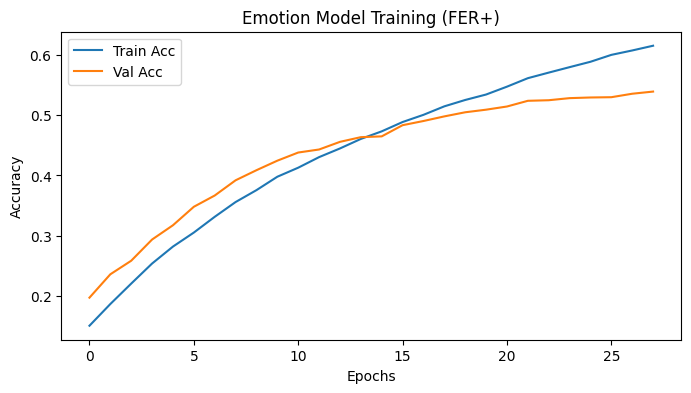

In [8]:
def plot_history(history, title="Training History"):
    plt.figure(figsize=(8,4))
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

plot_history(history, "Emotion Model Training (FER+)")


In [9]:
print("\nEvaluating on test set:")
test_results = emotion_model.evaluate(test_ds)
print("Test results (loss, accuracy):", test_results)


Evaluating on test set:
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5673 - loss: 1.2279
Test results (loss, accuracy): [1.2177200317382812, 0.5687097907066345]


In [10]:
# The 'emotion_model' object already holds the best weights due to 'restore_best_weights=True'
MODEL_PATH = "emotion_model_best.h5"

# 1. Save the final model in H5 format
emotion_model.save(MODEL_PATH)
print(f"✅ Model saved as {MODEL_PATH}")

# 2. Convert the saved H5 model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(emotion_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Applies default optimizations (quantization)
tflite_model = converter.convert()

# 3. Save the TFLite model
TFLITE_PATH = "emotion_model_best.tflite"
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print(f"✅ Model converted and saved as {TFLITE_PATH}")

✅ Model saved as emotion_model_best.h5
Saved artifact at '/tmp/tmpu99lqcpc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  132642681200784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681201168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681201552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681202128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681201360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681658576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681659728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681659344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681659920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132642681660304: TensorSpec(shape=(), dtype

W0000 00:00:1756613851.021755      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756613851.021811      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1756613851.171024      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
